导入数据

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.interpolate import interp1d
import time

# 计算IVIX

In [2]:
import tushare as ts
from IPython.display import clear_output

填写tushare的API密钥并且获取所有期权合约信息

In [ ]:
token = '你的tokens'
pro = ts.pro_api(token)
# 所有期权合约信息
opt_basic = pro.opt_basic(exchange="SSE")

## 各种计算

In [ ]:
class TushareRateLimiter:

    
    def __init__(self, max_calls_per_minute=59):
        self.max_calls = max_calls_per_minute
        self.call_times = []
    
    def wait_if_needed(self):

        now = time.time()
        
        # 移除一分钟前的调用记录
        self.call_times = [t for t in self.call_times if now - t < 60]
        
        # 如果达到限制，等待
        if len(self.call_times) >= self.max_calls:
            wait_time = 61  # 直接等待61秒
            print(f"\nAPI调用频率限制，等待 {wait_time} 秒...")
            time.sleep(wait_time)
            # 清空记录重新开始
            self.call_times = []
        
        # 记录本次调用
        self.call_times.append(now)
    
    def call_api(self, api_func, *args, **kwargs):

        self.wait_if_needed()
        return api_func(*args, **kwargs)

1.获取指定交易日的SHIBOR利率
2.构建不同期限(1天到365天)的利率曲线
3.使用线性插值方法创建利率插值函数
4.返回可用于任意期限利率计算的插值器

In [5]:
# 获取无风险利率，用SHIBOR
def get_rf(trade_date):
    shibor = pro.shibor(start_date=trade_date, end_date=trade_date)
    rf = pd.DataFrame()
    rf['tau'] = [1,7,14,30,180,270,365]
    rf['rate'] = shibor.iloc[0,1:].reset_index(drop=True)
    interp = interp1d(rf['tau'],rf['rate'],kind="linear",fill_value="extrapolate")
    return interp

1.获取指定交易日的期权日度数据
2.计算期权剩余到期天数(tau)
3.过滤掉剩余期限小于7天的合约
4.将期权数据分为近月和次近月两份
5.返回近月和次近月期权数据

In [6]:
# 获取期权数据，并分成近月和次近月两份
def opt_data(trade_date):
    opt_price = pro.opt_daily(trade_date=trade_date,exchange="SSE")
    opt_price_temp = opt_price[opt_price['exchange'] == 'SSE'].reset_index(drop=True)
    opt_basic_temp = opt_basic[(opt_basic['ts_code'].isin(opt_price_temp['ts_code']))&(opt_basic['opt_code']=='OP510050.SH')][
        ['ts_code','call_put','maturity_date','exercise_price']
    ].reset_index(drop=True)
    
    opt_price = pd.merge(opt_price_temp,opt_basic_temp,how='inner')
    opt_price['tau'] = (pd.to_datetime(opt_price['maturity_date']) - pd.to_datetime(opt_price['trade_date'])).apply(lambda x:x.days)
    opt_price = opt_price.sort_values(by=['tau','exercise_price']).reset_index(drop=True)
    opt_price = opt_price[opt_price['tau']>7].reset_index(drop=True)
    opt_near = opt_price[opt_price['tau'] == opt_price['tau'].drop_duplicates().nsmallest(2).tolist()[0] ].reset_index(drop=True)
    opt_2near = opt_price[opt_price['tau'] == opt_price['tau'].drop_duplicates().nsmallest(2).tolist()[1] ].reset_index(drop=True)
    return opt_near,opt_2near

按照CBOE VIX公式计算单个期限的波动率：
1.基于看涨-看跌期权平价关系
2.计算远期价格
3.确定平值期权执行价
4.加权求和计算方差
5.调整项处理

In [7]:
# 根据CBOE公式计算sigma
def cal_sigma(opt_df, interp):
    opt_df_call = opt_df[opt_df['call_put'] == "C"].sort_values(by=['exercise_price']).reset_index(drop=True)
    opt_df_put = opt_df[opt_df['call_put'] == "P"].sort_values(by=['exercise_price']).reset_index(drop=True)
    
    opt_df_call = opt_df_call[['trade_date','call_put','tau','exercise_price','close']].drop_duplicates(['tau','exercise_price'],keep='first').rename(columns={'close':'call_close'})
    opt_df_put = opt_df_put[['trade_date','call_put','tau','exercise_price','close']].drop_duplicates(['tau','exercise_price'],keep='first').rename(columns={'close':'put_close'})
    
    opt_df_merge = pd.merge(opt_df_call,opt_df_put,on=['tau','exercise_price'])
    opt_df_merge['diff_close'] = abs(opt_df_merge['call_close'] - opt_df_merge['put_close'])
    S = opt_df_merge[opt_df_merge['diff_close'] == opt_df_merge['diff_close'].min()]['exercise_price'].iloc[0]
    
    tau = opt_df_merge['tau'].unique().tolist()[0]
    opt_df_merge['R'] = interp(tau)/100
    opt_df_merge['F'] = S + np.exp( opt_df_merge['R'] * (tau/365) )*(opt_df_merge[opt_df_merge['exercise_price'] == S]['call_close'] - opt_df_merge[opt_df_merge['exercise_price'] == S]['put_close']).iloc[0]#.mean()
    opt_df_merge['F - Ki'] = opt_df_merge['F'] - opt_df_merge['exercise_price']
    
    try:
        opt_df_merge['K0'] = opt_df_merge[ opt_df_merge['F - Ki'] ==  opt_df_merge['F - Ki'][opt_df_merge['F - Ki']>0].nsmallest(1).iloc[0]]['exercise_price'].iloc[0]
    except Exception:
        opt_df_merge['K0'] = opt_df_merge[ opt_df_merge['F - Ki'] ==  opt_df_merge['F - Ki'].nsmallest(1).iloc[0]]['exercise_price'].iloc[0]

    opt_df_merge['PK'] = opt_df_merge.apply(lambda row: row['call_close'] if row['exercise_price']>row['K0'] else (row['put_close'] if row['exercise_price']<row['K0'] else (row['call_close']+row['put_close'])/2 ),axis=1)
    opt_df_merge['K_i+1'] = opt_df_merge['exercise_price'].shift(-1).fillna(opt_df_merge['exercise_price'].iloc[-1])
    opt_df_merge['K_i-1'] = opt_df_merge['exercise_price'].shift(1).fillna(opt_df_merge['exercise_price'].iloc[0])
    opt_df_merge['delta_K'] = (opt_df_merge['K_i+1'] - opt_df_merge['K_i-1'])/2
    opt_df_merge = opt_df_merge.dropna().reset_index(drop=True)
    
    opt_df_merge['sigma'] = 2/(opt_df_merge['tau']/365)*(opt_df_merge['delta_K']/opt_df_merge['exercise_price']**2)*np.exp(opt_df_merge['R']*opt_df_merge['tau']/365)*opt_df_merge['PK']
    sigma = opt_df_merge['sigma'].sum() - (1/(opt_df_merge['tau']/365)*((opt_df_merge['F']/opt_df_merge['K0']-1)**2)).iloc[0]
    return sigma

1.如果近月合约剩余期限≥30天，直接使用近月波动率
2.否则在近月和次近月波动率之间插值到30天期限
3.将结果年化并乘以100转换为百分比形式

In [8]:
# 对近月波动率和次近月波动率插值并年化得到IVIX
def cal_ivix(opt_df1, opt_df2, interp):
    tau1 = opt_df1['tau'].unique().tolist()[0]/365
    tau2 = opt_df2['tau'].unique().tolist()[0]/365
    if tau1 >=30:
        ivix = cal_sigma(opt_df1, interp)*100
    else:
        # 使用括号包裹多行表达式，避免使用反斜杠
        ivix = np.sqrt(
            (tau1 * cal_sigma(opt_df1, interp) * ((tau2 - 30/365)/(tau2 - tau1)) + 
             tau2 * cal_sigma(opt_df2, interp) * ((30/365 - tau1)/(tau2 - tau1))) * 365/30
        )
    return ivix

In [ ]:
def load_existing_results(file_path):

    try:
        existing_df = pd.read_csv(file_path)
        # 确保trade_date列是字符串类型进行比较
        existing_dates = set(existing_df['trade_date'].astype(str))
        return existing_df.to_dict('records'), existing_dates
    except FileNotFoundError:
        return [], set()
    ################################################################################
    ################################################################################
    ################################################################################
    ################################################################################
    # 自己加路径
def process_with_resume(date_list, output_file="", max_calls_per_minute=59):
    ################################################################################
    ################################################################################
    ################################################################################
    ################################################################################
    
    # 加载已有结果
    existing_results, processed_dates = load_existing_results(output_file)
    
    if existing_results:
        # 找到已处理数据中的最早日期
        existing_dates = [result['trade_date'] for result in existing_results]
        earliest_processed_date = min(existing_dates)
        print(f"已处理数据的最早日期: {earliest_processed_date}")
        
        # 过滤未处理的日期：只处理比最早日期更早的日期
        dates_to_process = [d for d in date_list['cal_date'].tolist() 
                           if str(d) not in processed_dates and int(d) < int(earliest_processed_date)]
    else:
        # 如果没有已处理的数据，处理所有日期
        dates_to_process = [d for d in date_list['cal_date'].tolist() 
                           if str(d) not in processed_dates]
    
    # 按时间顺序排序（从最近到最早）
    dates_to_process.sort(reverse=True)
    
    print(f"已处理 {len(processed_dates)} 个日期，剩余 {len(dates_to_process)} 个待处理")
    if dates_to_process:
        print(f"接下来处理的日期范围: {dates_to_process[-1]} 到 {dates_to_process[0]}")
    
    if not dates_to_process:
        print("所有日期都已处理完成！")
        return existing_results
    
    rate_limiter = TushareRateLimiter(max_calls_per_minute=max_calls_per_minute)
    failed_dates = []
    
    # 输出清理计数器
    output_clear_interval = 50  # 每50次清理一次输出
    
    for i, trade_date in enumerate(tqdm(dates_to_process)):
        try:
            # 定期清理输出（真正清理Jupyter单元格输出）
            if i > 0 and i % output_clear_interval == 0:
                clear_output(wait=True)  # 清理之前的输出
                print(f"已清理输出，继续处理... 当前进度: {i}/{len(dates_to_process)}")
                # 重新显示进度条
                pbar = tqdm(total=len(dates_to_process), initial=i)
            
            rate_limiter.wait_if_needed()
            
            interp = rate_limiter.call_api(get_rf, trade_date)
            opt_near, opt_2near = rate_limiter.call_api(opt_data, trade_date)
            ivix = cal_ivix(opt_near, opt_2near, interp)
            
            existing_results.append({
                'trade_date': trade_date,
                'ivix': ivix * 100
            })
            
            # 实时保存结果
            temp_df = pd.DataFrame(existing_results)
            temp_df['date'] = pd.to_datetime(temp_df['trade_date'].astype(str), format='%Y%m%d')
            temp_df.to_csv(output_file, index=False, encoding="utf_8_sig")
            
            print(f"{trade_date}: {ivix:.4f}")
            
        except Exception as e:
            error_msg = str(e)
            print(f"处理日期 {trade_date} 时出错: {error_msg}")
            failed_dates.append({'trade_date': trade_date, 'error': error_msg})
            
            # 如果是频率限制错误，等待更长时间
            if "每分钟最多访问该接口60次" in error_msg:
                print("触发频率限制，等待65秒...")
                time.sleep(65)
                # 重置频率限制器
                rate_limiter.call_times = []
            continue
    
    # 保存失败记录
    ################################################################################
    ################################################################################
    ################################################################################
    ################################################################################
    # 自己加路径
    if failed_dates:
        failed_df = pd.DataFrame(failed_dates)
        failed_df.to_csv("", index=False, encoding="utf_8_sig")
        print(f"\n有 {len(failed_dates)} 个日期处理失败，已保存")
    ################################################################################
    ################################################################################
    ################################################################################
    ################################################################################
    return existing_results

1.获取1999-2025年间的交易日历
2.筛选出开盘日
3.选择2020年10月20日到2025年10月20日期间的数据

In [10]:
# 循环计算
date = pro.query('trade_cal', start_date='19991230', end_date='20251231')
date_list = date[date['is_open']==1].reset_index(drop=True)
#你要算的日期在这里改
date_list = date_list[(date_list['cal_date']>'20150211')&(date_list['cal_date']<'20251001')].reset_index(drop=True)
#date_list = date_list[(date_list['cal_date'] == '20241204')].reset_index(drop=True)

In [11]:
import numpy as np

1.遍历每个交易日
2.获取当日无风险利率
3.获取当日期权数据
4.计算IVIX值
5.存储结果并显示进度

In [ ]:
    ################################################################################
    ################################################################################
    ################################################################################
    ################################################################################
    # 自己加路径
ivix_list = process_with_resume(date_list, "")
    ################################################################################
    ################################################################################
    ################################################################################
    ################################################################################

## 与真实IVIX进行对比

官方数据最后日期: 2018-02-14
计算数据最后日期: 2025-09-30


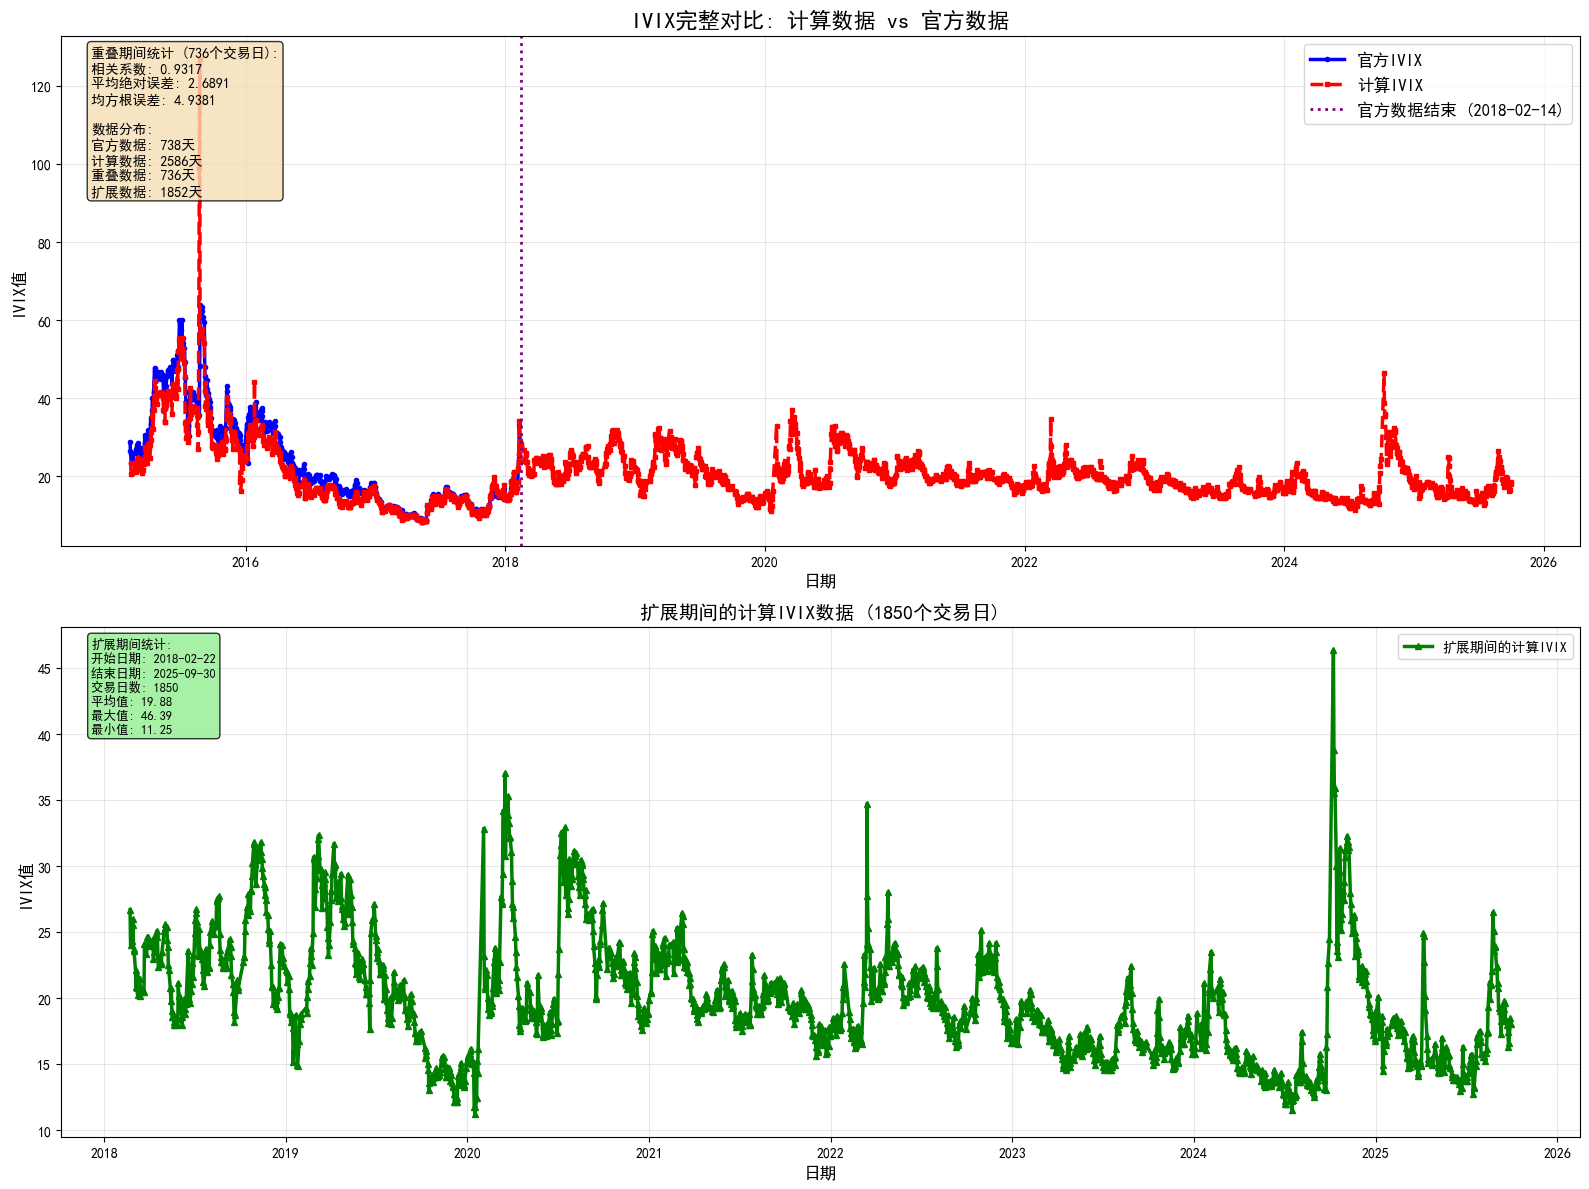

IVIX数据对比分析报告
官方数据时间范围: 2015-02-10 00:00:00 至 2018-02-14 00:00:00
计算数据时间范围: 2015-02-12 00:00:00 至 2025-09-30 00:00:00
完整数据时间范围: 2015-02-10 00:00:00 至 2025-09-30 00:00:00

数据统计:
  官方数据天数: 738
  计算数据天数: 2586
  重叠数据天数: 736
  扩展数据天数: 1852

重叠期间统计:
  相关系数: 0.9317
  平均绝对误差: 2.6891
  均方根误差: 4.9381

扩展期间统计:
  时间范围: 2018-02-22 00:00:00 至 2025-09-30 00:00:00
  交易日数: 1850
  IVIX平均值: 19.88
  IVIX最大值: 46.39
  IVIX最小值: 11.25

最新数据点:
  官方最新: 2018-02-14 - IVIX: 27.32
  计算最新: 2025-09-30 - IVIX: 18.02


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from datetime import datetime

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 读取实际的中国波指数据（官方数据）
    ################################################################################
    ################################################################################
    ################################################################################
    ################################################################################
    # 自己加路径
true_ivix = pd.read_csv("", encoding="GBK")
true_ivix['date'] = pd.to_datetime(true_ivix['日期'])
true_ivix['true_ivix'] = true_ivix['收盘价(元)']

# 读取计算出的IVIX数据
ivix = pd.read_csv("")
ivix['date'] = pd.to_datetime(ivix['date'])
    ################################################################################
    ################################################################################
    ################################################################################
    ################################################################################
# 找出官方数据的最后日期
official_end_date = true_ivix['date'].max()
print(f"官方数据最后日期: {official_end_date.strftime('%Y-%m-%d')}")
print(f"计算数据最后日期: {ivix['date'].max().strftime('%Y-%m-%d')}")

# 合并两个数据集 - 使用outer merge保留所有数据
df_all = pd.merge(true_ivix[['date','true_ivix']], ivix[['date','ivix']], on='date', how='outer')
df_all = df_all.sort_values('date').reset_index(drop=True)

# 添加年份列并筛选2014年之后的数据
df_all['year'] = df_all['date'].apply(lambda x:x.year)
df_all = df_all[df_all['year']>2014].reset_index(drop=True)

# 标记数据来源
df_all['data_type'] = '两者皆有'
df_all.loc[df_all['true_ivix'].isna(), 'data_type'] = '仅计算数据'
df_all.loc[df_all['ivix'].isna(), 'data_type'] = '仅官方数据'
df_all.loc[df_all['true_ivix'].notna() & df_all['ivix'].notna(), 'data_type'] = '两者重叠'

# 计算重叠期间的统计信息
df_overlap = df_all.dropna(subset=['true_ivix', 'ivix']).copy()
if len(df_overlap) > 0:
    correlation = df_overlap['true_ivix'].corr(df_overlap['ivix'])
    mae = (df_overlap['true_ivix'] - df_overlap['ivix']).abs().mean()
    rmse = np.sqrt(((df_overlap['true_ivix'] - df_overlap['ivix'])**2).mean())
else:
    correlation = mae = rmse = np.nan

# 创建图表
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

# 主图 - 完整时间序列对比
# 绘制官方数据（实际IVIX）
official_mask = df_all['true_ivix'].notna()
ax1.plot(df_all.loc[official_mask, 'date'], 
         df_all.loc[official_mask, 'true_ivix'], 
         label='官方IVIX', linewidth=2.5, color='blue', marker='o', markersize=3)

# 绘制计算数据
calculated_mask = df_all['ivix'].notna()
ax1.plot(df_all.loc[calculated_mask, 'date'], 
         df_all.loc[calculated_mask, 'ivix'], 
         label='计算IVIX', linewidth=2.5, color='red', linestyle='--', marker='s', markersize=3)

# 添加垂直线标记官方数据结束日期
ax1.axvline(x=official_end_date, color='purple', linestyle=':', linewidth=2, 
            label=f'官方数据结束 ({official_end_date.strftime("%Y-%m-%d")})')

ax1.legend(fontsize=12)
ax1.set_title('IVIX完整对比: 计算数据 vs 官方数据', fontsize=16, fontweight='bold')
ax1.set_xlabel('日期', fontsize=12)
ax1.set_ylabel('IVIX值', fontsize=12)
ax1.grid(True, alpha=0.3)

# 在图表上添加统计信息文本框
if len(df_overlap) > 0:
    stats_text = f'''重叠期间统计 ({len(df_overlap)}个交易日):
相关系数: {correlation:.4f}
平均绝对误差: {mae:.4f}
均方根误差: {rmse:.4f}

数据分布:
官方数据: {official_mask.sum()}天
计算数据: {calculated_mask.sum()}天
重叠数据: {len(df_overlap)}天
扩展数据: {len(df_all) - len(df_overlap)}天'''
else:
    stats_text = '无重叠数据可供比较'

ax1.text(0.02, 0.98, stats_text, transform=ax1.transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# 子图 - 扩展期间的数据（官方数据结束后的计算数据）
extension_start = official_end_date + pd.Timedelta(days=1)
extension_data = df_all[df_all['date'] > official_end_date]

if len(extension_data) > 0:
    ax2.plot(extension_data['date'], extension_data['ivix'], 
             label='扩展期间的计算IVIX', linewidth=2.5, color='green', marker='^', markersize=4)
    ax2.set_title(f'扩展期间的计算IVIX数据 ({len(extension_data)}个交易日)', fontsize=14)
    ax2.set_xlabel('日期', fontsize=12)
    ax2.set_ylabel('IVIX值', fontsize=12)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 在扩展数据图上添加统计信息
    extension_stats = f'''扩展期间统计:
开始日期: {extension_data["date"].min().strftime("%Y-%m-%d")}
结束日期: {extension_data["date"].max().strftime("%Y-%m-%d")}
交易日数: {len(extension_data)}
平均值: {extension_data["ivix"].mean():.2f}
最大值: {extension_data["ivix"].max():.2f}
最小值: {extension_data["ivix"].min():.2f}'''
    
    ax2.text(0.02, 0.98, extension_stats, transform=ax2.transAxes, fontsize=9,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
else:
    ax2.text(0.5, 0.5, '无扩展数据', transform=ax2.transAxes, 
             ha='center', va='center', fontsize=14)
    ax2.set_title('扩展期间数据', fontsize=14)

plt.tight_layout()
plt.show()

# 在控制台输出详细报告
print("="*60)
print("IVIX数据对比分析报告")
print("="*60)
print(f"官方数据时间范围: {true_ivix['date'].min()} 至 {true_ivix['date'].max()}")
print(f"计算数据时间范围: {ivix['date'].min()} 至 {ivix['date'].max()}")
print(f"完整数据时间范围: {df_all['date'].min()} 至 {df_all['date'].max()}")
print(f"\n数据统计:")
print(f"  官方数据天数: {official_mask.sum()}")
print(f"  计算数据天数: {calculated_mask.sum()}")
print(f"  重叠数据天数: {len(df_overlap)}")
print(f"  扩展数据天数: {len(df_all) - len(df_overlap)}")

if len(df_overlap) > 0:
    print(f"\n重叠期间统计:")
    print(f"  相关系数: {correlation:.4f}")
    print(f"  平均绝对误差: {mae:.4f}")
    print(f"  均方根误差: {rmse:.4f}")

if len(extension_data) > 0:
    print(f"\n扩展期间统计:")
    print(f"  时间范围: {extension_data['date'].min()} 至 {extension_data['date'].max()}")
    print(f"  交易日数: {len(extension_data)}")
    print(f"  IVIX平均值: {extension_data['ivix'].mean():.2f}")
    print(f"  IVIX最大值: {extension_data['ivix'].max():.2f}")
    print(f"  IVIX最小值: {extension_data['ivix'].min():.2f}")

print(f"\n最新数据点:")
latest_official = df_all[df_all['true_ivix'].notna()].iloc[-1] if official_mask.any() else None
latest_calculated = df_all[df_all['ivix'].notna()].iloc[-1] if calculated_mask.any() else None

if latest_official is not None:
    print(f"  官方最新: {latest_official['date'].strftime('%Y-%m-%d')} - IVIX: {latest_official['true_ivix']:.2f}")
if latest_calculated is not None:
    print(f"  计算最新: {latest_calculated['date'].strftime('%Y-%m-%d')} - IVIX: {latest_calculated['ivix']:.2f}")